In this project I will split customer`s emails into topics. Firstly, I will tokenize them and create vectors. Secondly, the optimal number of topics will be calculated using Silhouette score. Afterwards, I will split emails into topics using KMeans and LDA algorithms. Finally, I will build a clussification model to be able to predict the email topics in the future.

In [ ]:
# Run SparkSession locally
from pyspark.sql import SparkSession 
spark = SparkSession.builder \
.master("local[1]") \
.appName("pyspark.TopicModelling")\
.getOrCreate()

In [ ]:
spark

In [ ]:
# import modules 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType 
from pyspark.sql.functions import instr, col, lower, upper, translate,  regexp_replace 
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF 
import pyspark.sql.functions as f 
from pyspark.ml import Pipeline 
from pyspark.ml.clustering import KMeans 
from pyspark.ml.clustering import LDA 
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.feature import NGram

In [ ]:
# create schema 
schema = StructType(fields = [
    StructField("ID", StringType()), 
    StructField("From", StringType()), 
    StructField("To", StringType()), 
    StructField("Date", TimestampType()), 
    StructField("Content1", StringType()), 
    StructField("Content2", StringType())
])

In [ ]:
# import data 
df = spark.read\
.schema(schema)\
.option("header", "true")\
.csv("/content/drive/MyDrive/Data_fraud/chapter_4/enron_emails_clean.csv")

In [ ]:
# check number of rows 
df.count()

87319

In [ ]:
# display the first row 
df.show(1, truncate=False, vertical=True)

-RECORD 0------------------------------------------------
 ID       | <8345058.1075840404046.JavaMail.evans@thyme> 
 From     | ('advdfeedback@investools.com')              
 To       | ('advdfeedback@investools.com')              
 Date     | 2002-01-29 23:20:55                          
 Content1 | INVESTools Advisory                          
 Content2 | null                                         
only showing top 1 row



In [ ]:
# check "Content1" for null values
df.filter(f.isnull("Content1"))\
.count()

84417

In [ ]:
# drop null values based on "Content1" column 
df = df.dropna(subset=['Content1'])
df.count()

2902

In [ ]:
# create a new column "Concat" by concatenating "Content1", and "Content2"
df = df.withColumn("Concat", f.concat_ws(" ", "Content1", "Content2"))
df[['Concat']]\
.show(3, False, True)

-RECORD 0----------------------------------------------------------------------------------------------------------------
 Concat | INVESTools Advisory                                                                                            
-RECORD 1----------------------------------------------------------------------------------------------------------------
 Concat | ----- Forwarded by Richard B Sanders/HOU/ECT on 09/20/2000 07:07 PM -----                                      
-RECORD 2----------------------------------------------------------------------------------------------------------------
 Concat | hey you are not wearing your target purple shirt today are you?  I have mine on and I don't want to look silly 
only showing top 3 rows



# Tokenization

In [ ]:
# create a regular expression to remove digits and special characters 
reg_exp = r"(\d+|\#|\!|\?|\.|\,|\:|\/|\=|\-|\+|\(|\)|\"|\'|\;|\[|\])"
# create a new column "Concat_ml", based on "Concat" column for text tokenization
# remove unnecessary characters 
df = df.withColumn("Concat_ml", 
                   regexp_replace(lower(col("Concat")), reg_exp, " "))
# display a new column
df\
.select(f.col("Concat_ml"), f.col("Concat"))\
.show(3, False, True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------
 Concat_ml | investools advisory                                                                                            
 Concat    | INVESTools Advisory                                                                                            
-RECORD 1-------------------------------------------------------------------------------------------------------------------
 Concat_ml |       forwarded by richard b sanders hou ect on           pm                                                   
 Concat    | ----- Forwarded by Richard B Sanders/HOU/ECT on 09/20/2000 07:07 PM -----                                      
-RECORD 2-------------------------------------------------------------------------------------------------------------------
 Concat_ml | hey you are not wearing your target purple shirt today are you   i have mine on and i don t want to look silly 


In [ ]:
# tokenize "Concat_ml" 
tokenizer = Tokenizer(inputCol="Concat_ml", outputCol="Concat_words")
# instantiate stop words 
stop_words = StopWordsRemover.loadDefaultStopWords("english")
# remove stop words 
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="words_filtered", 
                       stopWords=stop_words)
# ngram = NGram(n=2, inputCol=swr.getOutputCol(), outputCol="ngrams")
# instantiate CountVectorizer 
count_vectorizer = CountVectorizer(inputCol=swr.getOutputCol(), 
                                   outputCol="word_vectors", 
                                   vocabSize=1000, 
                                   minDF=7)
# instantiate IDF model 
# idf_cv = IDF(inputCol="word_vectors", outputCol="features_cv", 
             # minDocFreq=7)
# preprocess data using pipeline 
preprocessing = Pipeline(stages=[tokenizer, 
                                 swr, 
                                 count_vectorizer])
# fit pipeline to the data 
preprocessing_model = preprocessing.fit(df)
preprocessing_data = preprocessing_model.transform(df)

In [ ]:
# check vectors 
preprocessing_data\
.select("word_vectors")\
.show(3, False, True)

-RECORD 0----------------------------------------------------------------------------
 word_vectors | (397,[],[])                                                          
-RECORD 1----------------------------------------------------------------------------
 word_vectors | (397,[0,9,19,21,104,173,202,325],[16.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) 
-RECORD 2----------------------------------------------------------------------------
 word_vectors | (397,[0,58,81,127,177],[2.0,1.0,1.0,1.0,1.0])                        
only showing top 3 rows



# Compute number of clusters using Silhouette score

In [ ]:
# evaluate KMeans model by calculating Silhouette score for different number of clusters
# select the right number of clusters
from pyspark.ml.evaluation import ClusteringEvaluator 
silhouette_score = []
# instantiate Evaluator with Silhouette measure using squared Euclidean distance 
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol="word_vectors", 
                                metricName="silhouette", 
                                distanceMeasure="squaredEuclidean")
# compute Silhouette measure for different number of clusters in a range
for i in range(3, 12):
  kmeans=KMeans(featuresCol="word_vectors", k=i)
  kmeans_fit = kmeans.fit(preprocessing_data)
  output = kmeans_fit.transform(preprocessing_data)
  # Compute silhouette score for diffrent number of clusters
  score = evaluator.evaluate(output)
  silhouette_score.append(score)
  print("Silhouette score: ", score)

Silhouette score:  0.9129624874002884
Silhouette score:  0.68231381459192
Silhouette score:  0.7364634179183308
Silhouette score:  0.6984728352233576
Silhouette score:  0.644080636301204
Silhouette score:  0.678732220705353
Silhouette score:  0.6452707086006462
Silhouette score:  0.6424984287076676
Silhouette score:  0.6686264176647466


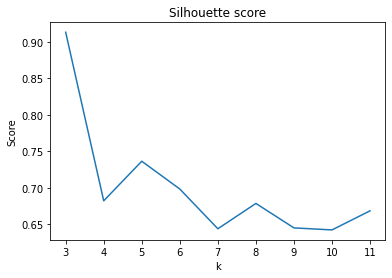

In [ ]:
# visualize silhouette score 
fig, ax=plt.subplots(figsize=(6,4))
ax.plot(range(3,12), silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.set_title("Silhouette score")
plt.show()

We can clearly see that the optimal number of clusters is 3 because of the highest Silhouette score of 0.9129624874002884. I will split e-mails into 3 clusters using KMeans and LDA models. 

# KMeans model with 3 clusters

In [ ]:
# create KMeans model 
kmeans = KMeans(featuresCol="word_vectors", k=3, seed=3545)
kmeans_model = kmeans.fit(preprocessing_data)
clustering_kmeans = kmeans_model.transform(preprocessing_data)

In [ ]:
# compute the size of the clusters
clustering_kmeans.groupBy("prediction")\
.agg(f.count("ID").alias("count"))\
.orderBy("prediction")\
.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  778|
|         1| 1937|
|         2|  176|
+----------+-----+



In [ ]:
# display the first 15 words of cluster 0
for i in np.argsort(kmeans_model.clusterCenters()[0])[:15]:
  print(preprocessing_model.stages[2].vocabulary[i])

security
involving
giron
shirley
darron
option>
dear
person
surprising
interests
steven
holdings
indirect
question
na


In [ ]:
# display the first 15 words of cluster 1 
for i in np.argsort(kmeans_model.clusterCenters()[1])[:15]:
  print(preprocessing_model.stages[2].vocabulary[i])

giron
clearly
optimal
rule
identify
involuntary
additional
experience
merchant
ancillary
darron
key
benefits
tuned
addressed


In [ ]:
# display the first 15 words of cluster 2 
for i in np.argsort(kmeans_model.clusterCenters()[2])[:15]:
  print(preprocessing_model.stages[2].vocabulary[i])

ken
able
dave
job
meeting
back
revised
industry
talked
lynn
hey
people
form
changed
fine


# LDA with 3 clusters

In [ ]:
# create LDA model
lda = LDA(featuresCol="word_vectors", seed=2385, k=3) 
lda_model = lda.fit(preprocessing_data)
topics_lda = lda_model.transform(preprocessing_data)

In [ ]:
# display topicDistribution column
topics_lda\
.select(f.col("topicDistribution"))\
.show(5, False, True)

-RECORD 0---------------------------------------------------------------------------
 topicDistribution | [0.0,0.0,0.0]                                                  
-RECORD 1---------------------------------------------------------------------------
 topicDistribution | [0.012474430024457523,0.9758788611094242,0.011646708866118342] 
-RECORD 2---------------------------------------------------------------------------
 topicDistribution | [0.7409908792770633,0.2181790081751091,0.0408301125478275]     
-RECORD 3---------------------------------------------------------------------------
 topicDistribution | [0.39080081058791216,0.5859081576320516,0.02329103178003622]   
-RECORD 4---------------------------------------------------------------------------
 topicDistribution | [0.39080081058791216,0.5859081576320516,0.02329103178003622]   
only showing top 5 rows



In [ ]:
lda_model.vocabSize()

397

In [ ]:
# check our 3 topics
lda_model\
.describeTopics(maxTermsPerTopic=15)\
.collect()

[Row(topic=0, termIndices=[0, 29, 81, 30, 36, 76, 59, 37, 79, 84, 72, 90, 100, 117, 127], termWeights=[0.14375050822777513, 0.01729099306737436, 0.016076063573412177, 0.014913549009464885, 0.012579496936003468, 0.011387154187624647, 0.010860801884284576, 0.010763561629976688, 0.008442271872798767, 0.008184265762825148, 0.008092859072129126, 0.007893671816104592, 0.007878453457075078, 0.007798407829401293, 0.007527668021461999]),
 Row(topic=1, termIndices=[0, 2, 3, 1, 9, 7, 4, 5, 8, 11, 12, 10, 18, 13, 14], termWeights=[0.614566981444358, 0.018132968814615777, 0.017696121151715476, 0.015655851534005904, 0.010520183692026553, 0.009732010005395815, 0.00963031291008453, 0.009096451073797618, 0.009087296800552128, 0.008972249272293434, 0.008944766505409178, 0.008880511627057027, 0.008843866813116094, 0.00884125264859584, 0.008834814134288015]),
 Row(topic=2, termIndices=[1, 20, 22, 6, 23, 25, 0, 33, 40, 42, 38, 31, 50, 52, 46], termWeights=[0.049985045342048354, 0.03334314495941579, 0.03059

In [ ]:
lda_model\
.describeTopics()\
.show(3)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[0, 29, 81, 30, 3...|[0.14375050822777...|
|    1|[0, 2, 3, 1, 9, 7...|[0.61456698144435...|
|    2|[1, 20, 22, 6, 23...|[0.04998504534204...|
+-----+--------------------+--------------------+



In [ ]:
# check words for topic 0 
for i in [0, 29, 81, 30, 36, 76, 59, 37, 79, 84, 72, 90, 100, 117, 127]:
  print(preprocessing_model.stages[2].vocabulary[i])


new
want
think
need
one
fyi
good
last
mail
work
th
week
office
look


In [ ]:
# check words for topic 1
for i in [0, 2, 3, 1, 9, 7, 4, 5, 8, 11, 12, 10, 18, 13, 14]:
  print(preprocessing_model.stages[2].vocabulary[i])


california
consumers
enron
forwarded
pay
employees
made
energy
low
millions
efforts
relief
provide
bills


In [ ]:
# check words for topic 2
for i in [1, 20, 22, 6, 23, 25, 0, 33, 40, 42, 38, 31, 50, 52, 46]:
  print(preprocessing_model.stages[-1].vocabulary[i])

enron
updates
com
please
questions
merger

dynegy
ve
many
home
stock
options
updated
additional


# Logistic regression model

In [ ]:
# take a sample of 80% of prediction data
train=clustering_kmeans.sampleBy("prediction", 
                                 fractions={0:0.8, 1:0.8, 2:0.8}, 
                                 seed=3435)\
                                 .cache()
# check the size of the labels 
train.groupBy("prediction").count().collect()

[Row(prediction=1, count=1551),
 Row(prediction=2, count=146),
 Row(prediction=0, count=615)]

In [ ]:
# take the rest of 20% data as test
test = \
clustering_kmeans.join(train, on="ID", how="leftanti")\
.cache()
# check the size of the labels
test.groupBy("prediction").count().collect()

[Row(prediction=1, count=371),
 Row(prediction=2, count=30),
 Row(prediction=0, count=142)]

In [ ]:
# drop unnessary columns and rename "prediction" to "target"
train = train.select("ID", "word_vectors", 
                     f.col("prediction").alias("target"))
test = test.select("ID", "word_vectors", 
                   f.col("prediction").alias("target"))

In [ ]:
# instantiate and fit LogisticRegression
lr = \
LogisticRegression(featuresCol=preprocessing_model.stages[2].getOutputCol(), 
                   labelCol='target', maxIter=20)
lr_model = lr.fit(train)
# make prediction 
predictions = lr_model.transform(test)
predictions.show(2, False, True)

-RECORD 0------------------------------------------------------------------------
 ID            | <8345058.1075840404046.JavaMail.evans@thyme>                    
 word_vectors  | (397,[],[])                                                     
 target        | 1                                                               
 rawPrediction | [-0.14926569441838625,16.424167675341447,-16.274901980923065]   
 probability   | [6.342336988922133E-8,0.9999999365766239,6.294691601192857E-15] 
 prediction    | 1.0                                                             
-RECORD 1------------------------------------------------------------------------
 ID            | <26118676.1075862176383.JavaMail.evans@thyme>                   
 word_vectors  | (397,[0,58,81,127,177],[2.0,1.0,1.0,1.0,1.0])                   
 target        | 1                                                               
 rawPrediction | [4.3417480931777,14.020451589475947,-18.362199682653653]        
 probability   |

In [ ]:
# compute f1 metric 
evaluator = \
MulticlassClassificationEvaluator(predictionCol='prediction',
                                  labelCol='target', 
                                  metricName='f1')
evaluator.evaluate(predictions)

0.8716988731011581

In [ ]:
# change f1 to weightedPrecision 
evaluator = evaluator.setMetricName("weightedPrecision")
evaluator.evaluate(predictions)

0.8726484688252821

In [ ]:
# compute weightedRecall 
evaluator = evaluator.setMetricName("weightedRecall")
evaluator.evaluate(predictions)

0.871086556169429

# Model tuning

In [ ]:
# set parameters 
paramGrid=\
ParamGridBuilder()\
.addGrid(lr.maxIter, [7, 14, 18])\
.addGrid(lr.regParam, [0.01, 0.03, 0.05, 0.07])\
.build()

In [ ]:
# cross validation 
crossval = \
CrossValidator(estimator=lr, 
               estimatorParamMaps=paramGrid, 
               evaluator=evaluator, 
               numFolds=3, 
               parallelism=5)
cv_model = crossval.fit(train)

In [ ]:
cv_model.avgMetrics

[0.818540692515362,
 0.8228354778835817,
 0.8228002803898785,
 0.8228724789142395,
 0.8411858279171934,
 0.8325064599095414,
 0.8279472567158538,
 0.8275581622676338,
 0.844755220629528,
 0.832837347506343,
 0.8266653632053115,
 0.8240821739004208]

In [ ]:
# grab the best model 
cv_model.bestModel

LogisticRegressionModel: uid=LogisticRegression_5b20f027ed3b, numClasses=3, numFeatures=397

In [ ]:
# compute predictions 
predictions = cv_model.transform(test)
# compute weightedRecall 
evaluator.evaluate(predictions)

0.8766114180478821

In [ ]:
# compute weightedPrecision
evaluator = evaluator.setMetricName("weightedPrecision")
evaluator.evaluate(predictions)

0.8735680911442688

In [ ]:
# compute f1 score 
evaluator = evaluator.setMetricName("f1")
evaluator.evaluate(predictions)

0.8719046385869054

The model has been improved across all metrics!